In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.feature_extraction.text import TfidfVectorizer
from stemming.porter2 import stem
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

## Load the dataset

In [2]:
df = pd.read_json('../Datasets/Sms_spam_1.json').sort_index()

## Explore the dataset

In [3]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5574, 2)

In [5]:
df['label'].unique()

array([0, 1])

In [6]:
df['label'].value_counts(normalize=True)

0    0.865985
1    0.134015
Name: label, dtype: float64

## Select the features

In [7]:
x = df['message']
y = df['label']

In [8]:
x.shape

(5574,)

## Split into train and test sets

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

## Define a stemming tokenizer

In [10]:
def tokenizer_porter(doc):
  return [stem(word) for word in doc.split()]

## Vectorize the messages

In [11]:
vectorizer = TfidfVectorizer(stop_words='english', tokenizer = tokenizer_porter)

In [12]:
x = vectorizer.fit_transform(df['message']).toarray()

In [13]:
x_train = vectorizer.fit_transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()

## Scale the features

In [14]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Dimensionality Reduction with PCA

In [15]:
pca = PCA(n_components=150)
x_train_r = pca.fit_transform(x_train)
x_test_r = pca.transform(x_test)

In [16]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.00233098,  0.00457342,  0.0067942 ,  0.00865516,  0.0104289 ,
        0.01216456,  0.01382373,  0.01547436,  0.01712089,  0.01873998,
        0.02031133,  0.02185614,  0.02339207,  0.02490795,  0.02641531,
        0.02791339,  0.0294051 ,  0.03086524,  0.03232263,  0.0337435 ,
        0.03516009,  0.0365469 ,  0.03792974,  0.03931144,  0.04066785,
        0.04202186,  0.04336735,  0.04470546,  0.04603128,  0.04734176,
        0.04864832,  0.04993747,  0.05120687,  0.05246068,  0.05371305,
        0.05496291,  0.05621103,  0.05745373,  0.05868473,  0.05991034,
        0.06113116,  0.06234675,  0.06355746,  0.06475934,  0.06595199,
        0.06714363,  0.06832942,  0.06951377,  0.0706892 ,  0.07186248,
        0.07303412,  0.07419592,  0.07535334,  0.07649903,  0.07764287,
        0.07878613,  0.07992907,  0.08106665,  0.08220371,  0.08333739,
        0.08446506,  0.08559   ,  0.08670705,  0.08782061,  0.08893136,
        0.09003855,  0.09114413,  0.09224115,  0.09333687,  0.09

## Hyperparameter optimization with cross-validation

In [17]:
estimator =  MLPClassifier(hidden_layer_sizes = (10), solver='lbfgs')

#alpha : L2 penalty parameter.

parameters ={'alpha': [0.01,0.1,1,10,100]}

grid_search = GridSearchCV(estimator, parameters, cv =5, n_jobs=-1)
grid_search.fit(x_train_r, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
grid_search.best_score_

0.97107659346545261

In [19]:
grid_search.best_params_

{'alpha': 10}

## Make predictions using the best model

In [20]:
model = grid_search.best_estimator_ #best model

In [21]:
y_pred = model.predict(x_test_r)

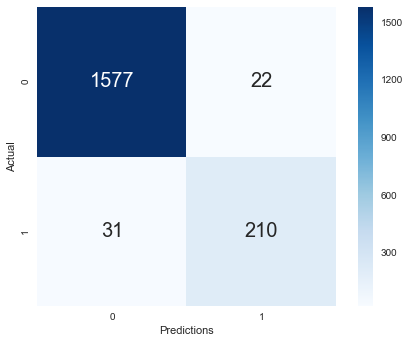

In [22]:
table = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predictions'])

sbn.heatmap(table, cbar=True, cmap='Blues',annot=True, square=True, fmt='d', annot_kws={'size': 20})
plt.show()

## Evaluate the best model

In [23]:
model.score(x_test_r,y_test) #Accuracy

0.97119565217391302

In [24]:
f1_score(y_test,y_pred)

0.88794926004228325